<a href="https://colab.research.google.com/github/omarsayed7/RSNA-Pneumonia-Detection/blob/master/RSNA_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Data download

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

In [0]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [0]:
!unzip rsna-pneumonia-detection-challenge.zip

# Overview

We’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs, a special 2D high resolution grayscale medical image. Note that pnuemonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.



In [40]:
!ls

'GCP Credits Request Link - RSNA.txt'	  stage_2_sample_submission.csv
 kaggle.json				  stage_2_test_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images
 sample_data				  stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


## Files description

`stage_2_detailed_class_info.csv`: Contains detailed information about the positive and negative classes in the training set

`stage_2_train_labels.csv`: CSV file containing training set patientIds and labels (including bounding boxes)

`stage_2_train_images`: Directory containing training set raw image (DICOM) files

`stage_2_test_images`: Directory containing test set raw image (DICOM) files

### Considerations
The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height

There is also a binary target column, Target, indicating pneumonia or non-pneumonia.

There may be multiple rows per patientId.

In [0]:
train_labels = pd.read_csv('stage_2_train_labels.csv')
data_info = pd.read_csv('stage_2_detailed_class_info.csv')
sample_submission = pd.read_csv('stage_2_sample_submission.csv')

In [42]:
sample_submission.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [38]:
data_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [22]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [23]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [0]:
sample = train_labels.iloc[0,:]
sample2 = train_labels.iloc[15,:]

In [25]:
sample

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object

In [26]:
sample2

patientId    00aecb01-a116-45a2-956c-08d2fa55433f
x                                             547
y                                             299
width                                         119
height                                        165
Target                                          1
Name: 15, dtype: object

As you can see the training data information consists of:

`patiendId` One unique value for each patient

`Target` Either 0 or 1 for absence or presence of pneumonia, respectively 

`x and y` The center of the bounding box, if the Target is 0 the value of x and y will be **NaN**

`width and height` The width and the height of the bounding box, if the Target is 0 the value of the width and the height will be **NaN**


---



### DICOM Images

All provided images are in DICOM format `(.dcm)`, DICOM(Digital Imaging and Communications in Medicine) is the international standard to transmit, store, retrieve, print, process, and display medical imaging information.

To make python deal with this format we are going to use `Pydicom` 

In [27]:
patientId = train_labels['patientId'][0]
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In order to get the pixel data from this metadata


In [28]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


# Visualization 

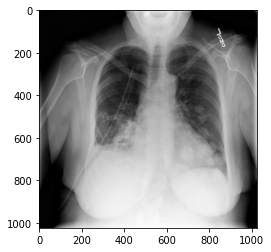

In [29]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)

## Utilities functions 

In [0]:
def get_sample(dataframe, img_dir, patientId):
  '''
  helper function used to parse a sample from the data 
  args:
  dataframe: pandas dataframe (e.g train, test)
  img_dir: directory to data images (.dcm)
  patientId: unique Id of the patient

  returns:
  gray scale image of the patient, bouding box values, target 
  '''
  x =[]
  y = []
  h = []
  w = []
  for i,j in zip(train_labels['patientId'],range(len(train_labels))):
    if i == patientId:
      patient = train_labels.iloc[j,:]
      x.append(patient[1])
      y.append(patient[2])
      w.append(patient[3])
      h.append(patient[4])
      target = patient[5]

      
  dcm_data = img_dir+'/%s.dcm' % patientId
  dcm_data = pydicom.read_file(dcm_file)
  img = dcm_data.pixel_array
  
  return img, x, y, h, w, target


  

In [0]:
def draw(img, x, y, h, w):
  '''
  helper function used to draw a bounding box/s of the areas of the lung
  args:
  img: grayscale image of the pateint's chest X-ray
  x,y,h,w: bounding box parameters 

  returns:
  grayscale images with drawn bounding box if exists
  '''
  fig,ax = plt.subplots(1)
  for x_sub,y_sub,h_sub,w_sub in zip(x, y, h, w):
    rect = patches.Rectangle((x_sub,y_sub),w_sub,h_sub,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  pylab.imshow(im, cmap=pylab.cm.gist_gray)
  ax.add_patch(rect)

  plt.show()



## Visualize Patients by ID

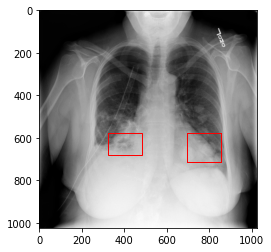

In [32]:
img, x, y, h, w, target = get_sample(dataframe = train_labels,img_dir = 'stage_2_train_images', patientId = '00704310-78a8-4b38-8475-49f4573b2dbb')
draw(img,x,y,h,w)

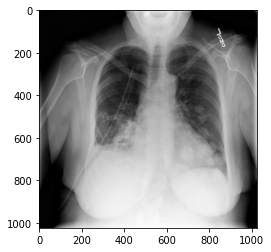

In [33]:
img, x, y, h, w, target = get_sample(dataframe = train_labels,img_dir = 'stage_2_train_images', patientId = '00322d4d-1c29-4943-afc9-b6754be640eb')
draw(img,x,y,h,w)

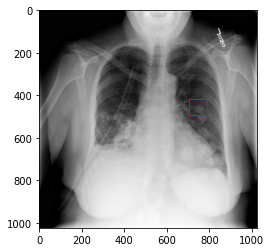

In [34]:
img, x, y, h, w, target = get_sample(dataframe = train_labels,img_dir = 'stage_2_train_images', patientId = '0100515c-5204-4f31-98e0-f35e4b00004a')
draw(img,x,y,h,w)

# Statistics 

In [35]:
print('Number of rows (unique boxes per patient) in main train dataset:', train_labels.shape[0])
print('Number of unique patient IDs:', train_labels['patientId'].nunique())


Number of rows (unique boxes per patient) in main train dataset: 30227
Number of unique patient IDs: 26684


Target
0    0.683892
1    0.316108
dtype: float64


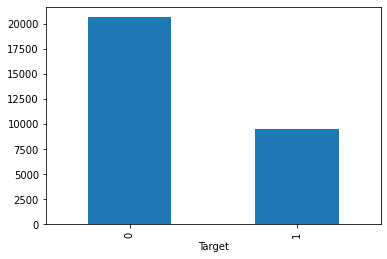

In [36]:
train_labels.groupby('Target').size().plot.bar()
print(train_labels.groupby('Target').size() / train_labels.shape[0])

## Detailed Class Info Data

However we may use the detailed information that been listed in `stage_2_detailed_class_info.csv`.

We revisit what is inside that file 



In [45]:
data_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


class
Lung Opacity                    0.316108
No Lung Opacity / Not Normal    0.391074
Normal                          0.292818
dtype: float64


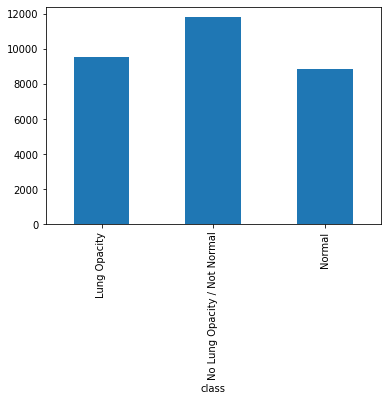

In [49]:
data_info.groupby('class').size().plot.bar()
print(data_info.groupby('class').size() / train_labels.shape[0])

As you can see we can add a new column called class to the training data, that will help us build more nuanced models.

Now we got general target called `Target` which contains only two classes `0 and 1`, 
and detailed target calsses `No Lung Opacity / Not Normal, Normal and Lung Opacity`

# Data preperation

# References 
* [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge?rvi=1)
* [Data exploratory Data Analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis)